## 0. Setting up the Environment


In [1]:
## impoort labaries 
import os 
import cv2
import mat73
import time
import keras
import pandas as pd
import numpy as np 
import seaborn as sns
import skimage
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image, ImageOps 
from skimage.transform import resize
from keras.models import Sequential
from tensorflow.keras import optimizers
from tqdm.notebook import tqdm_notebook as tqdm
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,  Convolution2D

## 1. Data Importing 

In [2]:
SIZE_X = 128
SIZE_Y = 128
SIZE_Z = 1
CLASS_NUM = 6

aug_train_DF = pd.read_pickle(r"../../../Datasets/Dataset_B_2/aug_train_DF_{}.pkl".format(SIZE_X))
aug_val_DF = pd.read_pickle(r"../../../Datasets/Dataset_B_2/aug_val_DF_{}.pkl".format(SIZE_X))
aug_test_DF = pd.read_pickle(r"../../../Datasets/Dataset_B_2/aug_test_DF_{}.pkl".format(SIZE_X))

In [3]:
## Combain the df with the Pitutary & Meningioma types with the dataframe of the Glioma grades (I, II,, IV).
pd.concat([aug_train_DF, aug_val_DF, aug_test_DF], axis=0, ignore_index = True).sample(5)

,PID,Label,Image,File
3101,Heatly_dataset_#998,No tumor,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",no331.jpg
12013,Heatly_dataset_#998,No tumor,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",no1263.jpg
1400,HF1397,Glioma VI,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",D:\Datasets\manifest-tXudPFfp43472957274060920...
15074,97607,Meningioma,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",665.mat
4063,107505,Pituitary,"[[0.0, 0.0009803921568628277, 0.00196078431372...",1190.mat


In [4]:
pd.concat([aug_train_DF, aug_val_DF, aug_test_DF], axis=0, ignore_index = True).info(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18612 entries, 0 to 18611
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   PID     18612 non-null  object
 1   Label   18612 non-null  object
 2   Image   18612 non-null  object
 3   File    18612 non-null  object
dtypes: object(4)
memory usage: 581.8+ KB


C:\Users\Ma7moud\anaconda3\envs\T-UNet\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


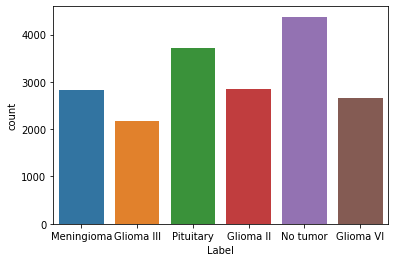

In [5]:
sns.countplot(pd.concat([aug_train_DF, aug_val_DF, aug_test_DF], axis=0, ignore_index = True).Label)
plt.show()

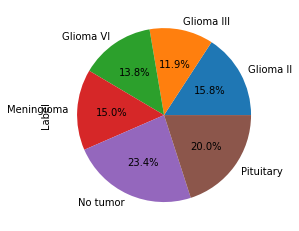

In [6]:
data = aug_train_DF.groupby("Label")["Label"].count()
data.plot.pie(autopct="%.1f%%");

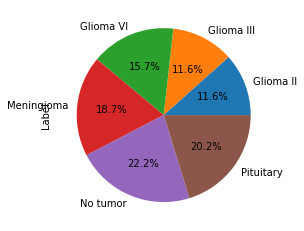

In [7]:
data = aug_val_DF.groupby("Label")["Label"].count()
data.plot.pie(autopct="%.1f%%");

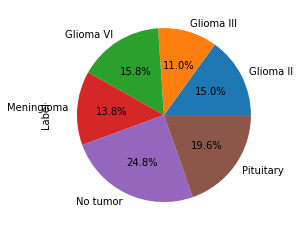

In [8]:
data = aug_test_DF.groupby("Label")["Label"].count()
data.plot.pie(autopct="%.1f%%");

## 2. Data-Preprocessing 

### 2.1 Image Resizing 


### 2.2 Data Augmentation

### 2.3 Grayscale to RGB

In [9]:
def normalize(img):
    plt.imsave('DR.png', img, cmap='gray')
    return cv2.imread('DR.png')[:, :, SIZE_Z]

In [10]:
aug_train_DF["Image"] = aug_train_DF["Image"].apply(normalize)
aug_val_DF["Image"] = aug_val_DF["Image"].apply(normalize)
aug_test_DF["Image"] = aug_test_DF["Image"].apply(normalize)

### 2.4 Splitting Data into Train, Test, and Validation Sets

In [11]:
y_train = aug_train_DF["Label"]
X_train = aug_train_DF['Image'].tolist()
X_train = np.array(X_train).reshape(-1, SIZE_X, SIZE_Y, SIZE_Z)


y_val = aug_val_DF["Label"]
X_val = aug_val_DF['Image'].tolist()
X_val = np.array(X_val).reshape(-1, SIZE_X, SIZE_Y, SIZE_Z)

y_test = aug_test_DF["Label"]
X_test = aug_test_DF['Image'].tolist()
X_test = np.array(X_test).reshape(-1, SIZE_X, SIZE_Y, SIZE_Z)


In [12]:
print("X_train shape:", X_train.shape,"| y_train shape:", y_train.shape)
print("X_val shape  :",X_val.shape," | y_test shape : ", y_val.shape)
print("X_test shape :",X_test.shape," | y_test shape : ", y_test.shape)

X_train shape: (13960, 128, 128, 1) | y_train shape: (13960,)
X_val shape  : (1860, 128, 128, 1)  | y_test shape :  (1860,)
X_test shape : (2792, 128, 128, 1)  | y_test shape :  (2792,)


### 2.5 One-Hot Encode the labels 

In [13]:
# saving a copy of the testing labels before one hot encoding
y_test_eval = y_test
# one hot endcoding the labels 
y_train = pd.get_dummies(y_train)
y_test  = pd.get_dummies(y_test)
y_val   = pd.get_dummies(y_val)

In [14]:
print("X_train shape:", X_train.shape,"| y_train shape:", y_train.shape)
print("X_test shape :",X_test.shape," | y_test shape: ", y_test.shape)
print("X_val shape  :",X_val.shape," | y_val shape : ", y_val.shape)
print("\nTotal number: {}".format(len(aug_train_DF)+len(aug_val_DF)+len(aug_test_DF)))

X_train shape: (13960, 128, 128, 1) | y_train shape: (13960, 6)
X_test shape : (2792, 128, 128, 1)  | y_test shape:  (2792, 6)
X_val shape  : (1860, 128, 128, 1)  | y_val shape :  (1860, 6)

Total number: 18612


In [15]:
y_test

,Glioma II,Glioma III,Glioma VI,Meningioma,No tumor,Pituitary
0,0,0,0,0,1,0
1,0,0,0,0,1,0
2,0,0,1,0,0,0
3,0,0,0,0,0,1
4,0,0,1,0,0,0
...,...,...,...,...,...,...
2787,0,0,0,0,0,1
2788,0,0,0,0,0,1
2789,0,0,0,0,1,0
2790,0,1,0,0,0,0


### 2.6 Image Normalizatoin

In [16]:
X_train = X_train / 255
X_val   = X_val / 255
X_test  = X_test / 255

In [17]:
## This Dictionary is used to decode the model's predicted values.  
decode_dict = {0 : "Glioma II", 1 : "Glioma III", 2 : "Glioma VI", 3: "Meningioma", 4: "No tumor", 5: "Pituitary"}

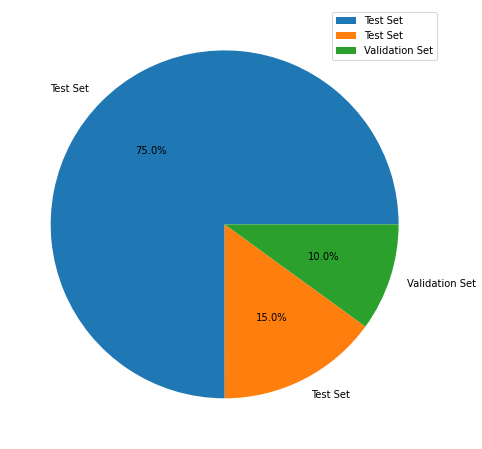

In [18]:
import matplotlib.pyplot as plt
import numpy as np
##  Creating a Pie chart illustrating the percentage of the train, validation, test sets.
Data = np.array([len(y_train), len(y_test), len(y_val)])
mylabels = ["Test Set", "Test Set", "Validation Set"]
plt.figure(figsize=(13, 8))
plt.pie(Data, labels = mylabels, autopct="%.1f%%", )
plt.legend()
plt.show() 

## 3. Models Creation


In [19]:
m1 = Sequential()

m1.add(Convolution2D( 32, (3,3), activation ='relu', input_shape = (SIZE_X, SIZE_Y, SIZE_Z))) 
m1.add(MaxPooling2D(pool_size=2))
m1.add(Convolution2D(filters=64, kernel_size=4, padding='same', activation='relu'))
m1.add(MaxPooling2D(pool_size=2))
m1.add(Convolution2D(filters=128, kernel_size=3, padding='same', activation='relu'))
m1.add(MaxPooling2D(pool_size=2))
m1.add(Dropout(0.50))
m1.add(Convolution2D(filters=128, kernel_size=2, padding='same', activation='relu'))
m1.add(MaxPooling2D(pool_size=2))
m1.add(Dropout(0.50))
m1.add(Flatten()) 
m1.add(Dense(units = 128, activation = 'relu'))
m1.add(Dense(units = 32, activation = 'relu'))
m1.add(Dense(units = CLASS_NUM, activation = 'softmax'))

m1.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

### 4. Model Training


In [20]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 30 )

m1.fit(X_train,y_train,epochs=150,batch_size=16, validation_data=(X_val,y_val), callbacks = [early_stop], verbose=1)

Epoch 1/150
873/873 [==============================] - 10s 9ms/step - loss: 0.8918 - accuracy: 0.6390 - val_loss: 0.5222 - val_accuracy: 0.7935
Epoch 2/150
873/873 [==============================] - 7s 8ms/step - loss: 0.4610 - accuracy: 0.8112 - val_loss: 0.3993 - val_accuracy: 0.8382
Epoch 3/150
873/873 [==============================] - 7s 8ms/step - loss: 0.3565 - accuracy: 0.8564 - val_loss: 0.3511 - val_accuracy: 0.8688
Epoch 4/150
873/873 [==============================] - 7s 8ms/step - loss: 0.2840 - accuracy: 0.8895 - val_loss: 0.3251 - val_accuracy: 0.8640
Epoch 5/150
873/873 [==============================] - 7s 8ms/step - loss: 0.2423 - accuracy: 0.9055 - val_loss: 0.2818 - val_accuracy: 0.8941
Epoch 6/150
873/873 [==============================] - 7s 8ms/step - loss: 0.2060 - accuracy: 0.9186 - val_loss: 0.2424 - val_accuracy: 0.8984
Epoch 7/150
873/873 [==============================] - 7s 8ms/step - loss: 0.1831 - accuracy: 0.9282 - val_loss: 0.2335 - val_accuracy: 0.900

In [21]:
# Get training history
metrics = pd.DataFrame(m1.history.history)

In [22]:
import os
exp_num = []
if not os.path.exists("./experiments"):
    os.mkdir("./experiments")
folders = os.listdir("./experiments")
for folder in folders:
    exp_num.append(int(folder.split("#")[1]))


if len(exp_num) == 0:
    exp_path = r"./experiments/exp#1"
else:
    exp_path = r"./experiments/exp#"+str(max(exp_num)+1)




os.mkdir(exp_path)
os.mkdir(os.path.join(exp_path, "results"))
os.mkdir(os.path.join(exp_path, "weights"))

results = os.path.join(exp_path, "results")
weights = os.path.join(exp_path, "weights")

In [23]:
print(results)

./experiments/exp#7\results


In [24]:
# Save The Trained model along with it training history   
Accuracy = m1.evaluate(X_test, y_test)[-1]
name = str(round(Accuracy, 4))

metrics.to_pickle(os.path.join(results, name+'.pkl'))
m1.save(os.path.join(weights, name + '.h5'))

88/88 [==============================] - 1s 5ms/step - loss: 0.2873 - accuracy: 0.9391


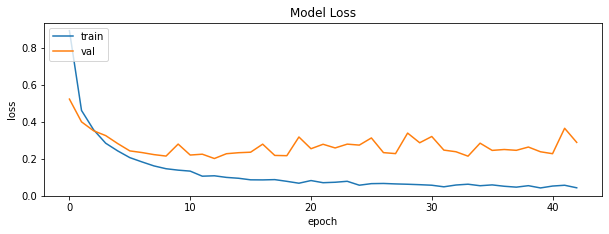

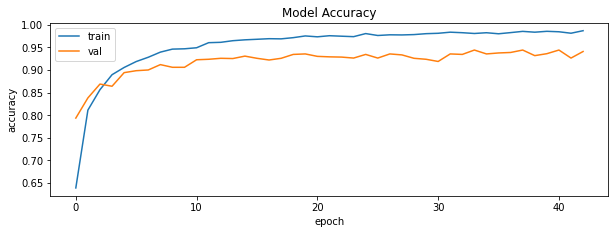

In [25]:
## Dispaly the plot of 
rows = 2
columns = 1
  
# Display Train loss vs Validation loss at each Epoch
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(rows, columns, 1)
plt.plot(metrics['loss'])
plt.plot(metrics['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(os.path.join(results, 'loss_epoch.png'))
plt.show()

  
# Display Train loss vs Validation loss at each Epoch
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(rows, columns, 2)
plt.plot(metrics['accuracy'])
plt.plot(metrics['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(os.path.join(results, 'acc_epoch.png'))
plt.show()



In [26]:
## Get the 
predict_x = m1.predict(X_test) 
predictions = np.argmax(predict_x,axis=1) 

In [27]:
# Decode the Model's predections  (from [0,1,0,2..] to ['Glioma','Meningioma'...]) of the Test set using the the dictionary 'decode_dict' 
predictions = np.vectorize(decode_dict.get)(predictions)

In [28]:
print(classification_report(y_test_eval, predictions))

              precision    recall  f1-score   support

   Glioma II       0.87      0.90      0.88       420
  Glioma III       0.85      0.86      0.86       308
   Glioma VI       0.92      0.89      0.91       440
  Meningioma       0.95      0.97      0.96       384
    No tumor       0.99      1.00      0.99       692
   Pituitary       0.98      0.96      0.97       548

    accuracy                           0.94      2792
   macro avg       0.93      0.93      0.93      2792
weighted avg       0.94      0.94      0.94      2792



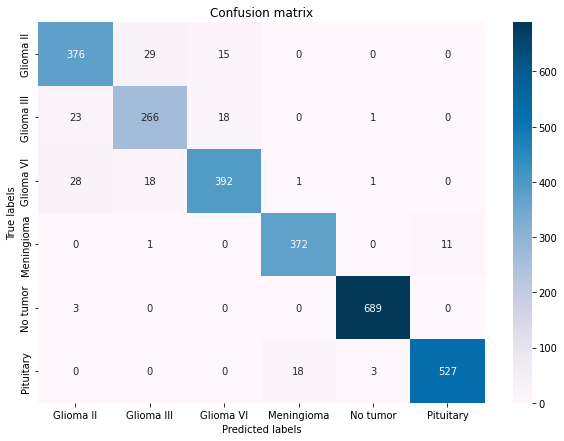

In [29]:
labels = sorted(aug_test_DF.Label.unique())

cm = pd.DataFrame(confusion_matrix(y_test_eval, predictions), index=labels, columns=labels)
plt.figure(figsize = (10,7))
plt.title('Confusion matrix')
sns.heatmap(cm, annot=True, cmap="PuBu",fmt = 'd')
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.savefig(os.path.join(results, 'confusion_matrix.png'))
plt.show()

In [30]:
sorted(aug_test_DF.Label.unique())

['Glioma II', 'Glioma III', 'Glioma VI', 'Meningioma', 'No tumor', 'Pituitary']

In [31]:
len(aug_test_DF[aug_test_DF.Label == "No tumor"])

692